In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import networkx as nx
from networkx.algorithms import bipartite
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('rappler-business-with-ner-timestep-sentiment-score.csv')
df.head()

,Unnamed: 0,date,id,link,categories,authorship,tags,unique_entities,author.name,time_step,sentiment_score
0,0,2022-01-01 12:59:53,1542619,https://www.rappler.com/business/bohol-starts-...,"[621, 624, 701]",[2573],"[1263, 2814, 2290]","['Typhoon Odette', 'Arthur Yap']",NaN,0,0.055859
1,1,2022-01-01 19:54:55,1543036,https://www.rappler.com/business/turkey-lira-c...,"[621, 622]",[5083],"[2625, 1870, 1235]","['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...",NaN,0,0.007710
2,2,2022-01-01 20:29:57,1543064,https://www.rappler.com/business/indonesia-ban...,"[621, 622, 624]",[5083],"[2716, 1141, 2290]","['Ridwan Jamaludin', 'Perusahaan Listrik Negar...",NaN,0,-0.014912
3,3,2022-01-02 11:34:10,1543150,https://www.rappler.com/business/department-tr...,"[621, 628, 622]",[4270],"[3029, 2802]","['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...",Michelle Abad,0,-0.025336
4,4,2022-01-03 21:00:57,1544290,https://www.rappler.com/business/indonesia-min...,"[621, 624]",[5083],"[2716, 1141, 2648]","['Perusahaan Listrik Negara', 'Puneet Gupta', ...",NaN,0,0.004880


In [3]:
entities = []
for e in df['unique_entities']:
    entities += eval(e)
print('There are', df['id'].nunique(), 'unique news articles.')
print('There are', len(entities), 'mentions of unique entities.')
print('There are', len(np.unique(entities)), 'unique entities.')

There are 2871 unique news articles.
There are 12742 mentions of unique entities.
There are 6858 unique entities.


## Entities linked by Existence in Articles

In [4]:
df['unique_entities']

0                        ['Typhoon Odette', 'Arthur Yap']
1       ['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...
2       ['Ridwan Jamaludin', 'Perusahaan Listrik Negar...
3       ['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...
4       ['Perusahaan Listrik Negara', 'Puneet Gupta', ...
                              ...                        
2866    ['Josephine Gotianun Yap', 'Jaime Bautista', '...
2867       ['Ronald Jason J Ramos', 'The Zobel de Ayala']
2868    ['Dennis Uy', 'Enrique Razon', 'Dennis Uy', 'R...
2869    ['Tayyip Erdogan', 'Daleep Singh', 'Colin Grah...
2870                ['Edgar Galvante', 'Rodrigo Duterte']
Name: unique_entities, Length: 2871, dtype: object

In [5]:
# Create an empty graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(df['id'], article=1)  # Add article nodes
# All entities from the 'unique_entities' column
all_entities = [entity for sublist in df['unique_entities'] for entity in eval(sublist)]
B.add_nodes_from(set(all_entities), article=0)  # Add entity nodes

# Add edges between articles and entities
for index, row in tqdm(df.iterrows()):
    article_id = row['id']
    entities = eval(row['unique_entities'])
    for entity in entities:
        B.add_edge(article_id, entity)

0it [00:00, ?it/s]

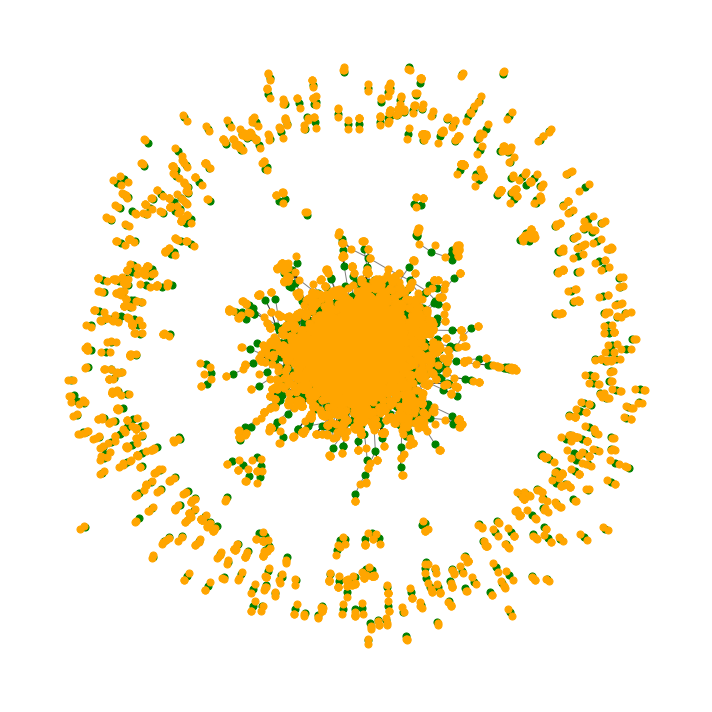

In [6]:
# Determine the nodes for each partition based on the 'bipartite' attribute
article_nodes = [n for n, d in B.nodes(data=True) if d['article']==1]
entity_nodes = [n for n, d in B.nodes(data=True) if d['article']==0]

# Create the bipartite layout
pos = nx.spring_layout(B, seed=34)

# Draw the graph
plt.figure(figsize=(10,10))

# Nodes
nx.draw_networkx_nodes(B, pos, nodelist=article_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(B, pos, nodelist=entity_nodes, node_color='orange', node_size=50)

# Edges
nx.draw_networkx_edges(B, pos, width=1, alpha=0.5)  # added alpha for transparency

# If you want to show labels, uncomment the following line. Given the bipartite nature, it might clutter the visualization.
# nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.savefig('bipartite_graph.png', dpi=100)
plt.show()


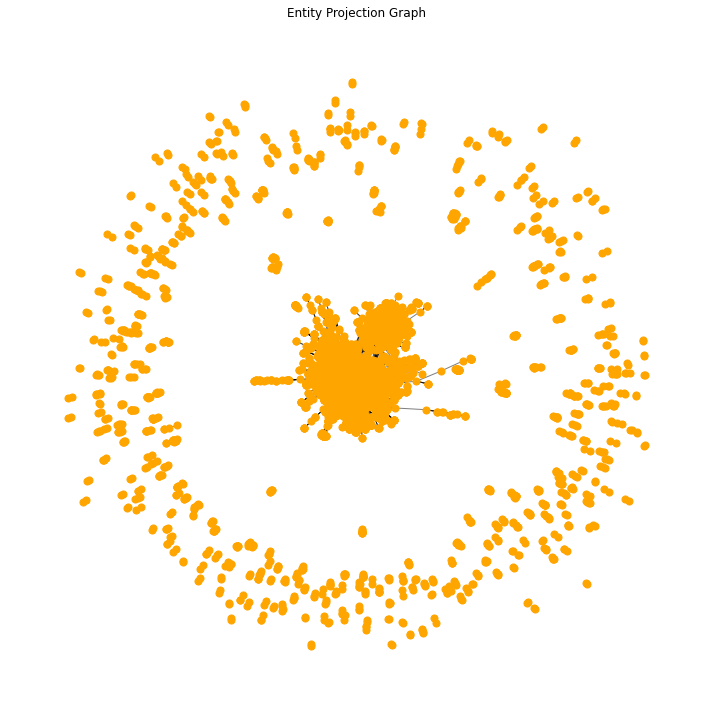

In [7]:
# 1. Create the entity projection
# Project the bipartite graph onto the entities nodes
entity_projection = nx.bipartite.projected_graph(B, entity_nodes)

# 2. Visualize the entity projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(entity_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(entity_projection, pos, node_color='orange', node_size=50)
nx.draw_networkx_edges(entity_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(entity_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Entity Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('entity_projection_graph.png', dpi=100)
plt.show()


In [8]:
# Sort nodes by degree in descending order
sorted_degree = sorted(dict(entity_projection.degree()).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree, columns=['Node', 'Degree'])

df_top_10

,Node,Degree
0,Joe Biden,582
1,Ferdinand Marcos Jr,529
2,Vladimir Putin,474
3,Rodrigo Duterte,311
4,Jerome Powell,302
5,Janet Yellen,251
6,Liz Truss,206
7,Xi Jinping,194
8,Donald Trump,171
9,Benjamin Diokno,168


In [9]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(entity_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(entity_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.8138172784173052


In [10]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(nx.degree_centrality(entity_projection).items(), key=lambda item: item[1], reverse=True)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality

,Node,Degree Centrality
0,Joe Biden,0.084877
1,Ferdinand Marcos Jr,0.077147
2,Vladimir Putin,0.069126
3,Rodrigo Duterte,0.045355
4,Jerome Powell,0.044043
5,Janet Yellen,0.036605
6,Liz Truss,0.030042
7,Xi Jinping,0.028292
8,Donald Trump,0.024938
9,Benjamin Diokno,0.024501


In [11]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness

,Node,Closeness Centrality
0,Joe Biden,0.331680
1,Vladimir Putin,0.296103
2,Donald Trump,0.294322
3,Xi Jinping,0.291003
4,Janet Yellen,0.285571
5,Kristalina Georgieva,0.279463
6,Jerome Powell,0.278704
7,Ferdinand Marcos Jr,0.276815
8,Rishi Sunak,0.275654
9,Ursula von der Leyen,0.273379


In [12]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(entity_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness

,Node,Betweenness Centrality
0,Joe Biden,0.226469
1,Ferdinand Marcos Jr,0.129743
2,Vladimir Putin,0.098049
3,Xi Jinping,0.063792
4,Donald Trump,0.058784
5,Rodrigo Duterte,0.057871
6,Jerome Powell,0.050466
7,Janet Yellen,0.037458
8,Rishi Sunak,0.024459
9,Elon Musk,0.022282


In [13]:
# 6. Density
density = nx.density(entity_projection)
print(f"Density: {density}")

Density: 0.0013365144290608125


## Articles linked by Similar Entities

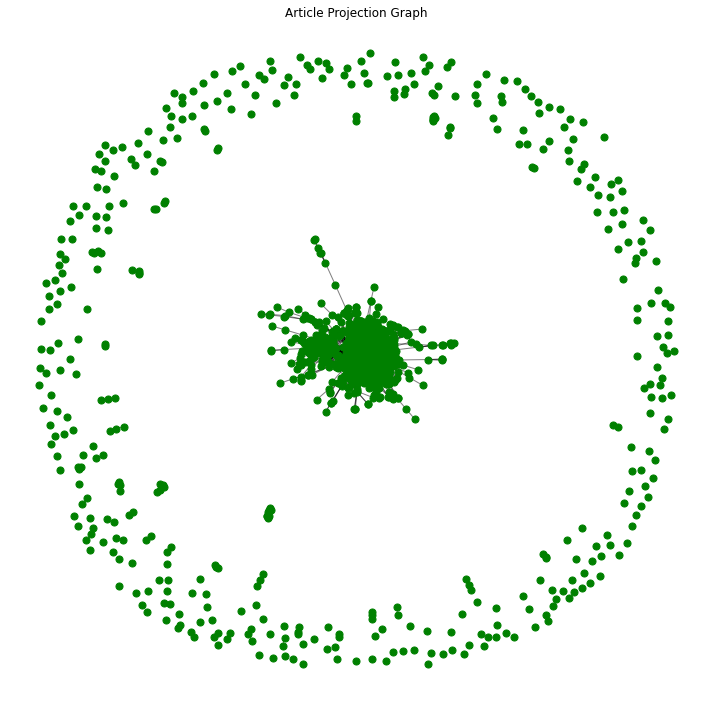

In [14]:
# 1. Create the article projection
# Project the bipartite graph onto the article nodes
article_projection = nx.bipartite.projected_graph(B, article_nodes)

# 2. Visualize the article projection graph
# Use the spring layout for positioning
pos = nx.spring_layout(article_projection, seed=34)

plt.figure(figsize=(10,10))

# Draw nodes and edges
nx.draw_networkx_nodes(article_projection, pos, node_color='green', node_size=50)
nx.draw_networkx_edges(article_projection, pos, alpha=0.5)

# Labels can be added if desired, but with many nodes, it might be cluttered.
# If you want to show labels for specific important nodes or all nodes, you can uncomment the following line.
# nx.draw_networkx_labels(article_projection, pos, font_size=10, font_family='sans-serif')

plt.title("Article Projection Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('article_projection_graph.png', dpi=100)
plt.show()



In [15]:
df['article_title'] = df['link'].str.split('/').apply(lambda x: x[-2])

In [16]:
# Sort nodes by degree in descending order
sorted_degree = sorted(
    dict(article_projection.degree()).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degrees
top_10_degree = sorted_degree[:10]

# Convert to a pandas DataFrame
df_top_10 = pd.DataFrame(top_10_degree,
                         columns=['Node', 'Degree'])

df_top_10['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10.Node
].tolist()

df_top_10

,Node,Degree,titles
0,1750778,594,united-states-federal-reserve-white-house-slow...
1,1563360,545,updates-global-stock-markets-oil-prices-januar...
2,1646105,524,united-states-sanctions-russia-sberbank-putin-...
3,2276457,510,artificial-intelligence-race-canva-draws-line-...
4,1596589,482,momentum-grows-ban-russia-swift-payment-system...
5,1631758,469,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,468,united-states-european-union-liquefied-natural...
7,1600144,466,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,466,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,465,united-states-allies-target-russia-swift-ban-c...


In [17]:
# 2. Clustering Coefficient
clustering_coefficient = nx.clustering(article_projection)
print(f"Average Clustering Coefficient: {nx.average_clustering(article_projection)}")

# not interesting since all entities appearing in a single article will surely have 1

Average Clustering Coefficient: 0.6367534381915688


In [18]:
# Sort nodes by degree centrality in descending order
sorted_degree_centrality = sorted(
    nx.degree_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their degree centralities
top_10_degree_centrality = sorted_degree_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_degree_centrality = pd.DataFrame(top_10_degree_centrality, columns=['Node', 'Degree Centrality'])

df_top_10_degree_centrality['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_degree_centrality.Node
].tolist()

df_top_10_degree_centrality

,Node,Degree Centrality,titles
0,1750778,0.206969,united-states-federal-reserve-white-house-slow...
1,1563360,0.189895,updates-global-stock-markets-oil-prices-januar...
2,1646105,0.182578,united-states-sanctions-russia-sberbank-putin-...
3,2276457,0.177700,artificial-intelligence-race-canva-draws-line-...
4,1596589,0.167944,momentum-grows-ban-russia-swift-payment-system...
5,1631758,0.163415,china-sinopec-pauses-russia-projects-wary-sanc...
6,1631719,0.163066,united-states-european-union-liquefied-natural...
7,1600144,0.162369,china-boosts-oil-reserves-ignoring-united-stat...
8,2123714,0.162369,russia-says-nord-stream-likely-hit-state-backe...
9,1597716,0.162021,united-states-allies-target-russia-swift-ban-c...


In [19]:
# Sort nodes by closeness centrality in descending order
sorted_closeness_centrality = sorted(
    nx.closeness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True
)

# Get the top 10 nodes and their closeness centralities
top_10_closeness_centrality = sorted_closeness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_closeness = pd.DataFrame(top_10_closeness_centrality, columns=['Node', 'Closeness Centrality'])

df_top_10_closeness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_closeness.Node
].tolist()

df_top_10_closeness

,Node,Closeness Centrality,titles
0,2276457,0.405815,artificial-intelligence-race-canva-draws-line-...
1,1750778,0.405179,united-states-federal-reserve-white-house-slow...
2,1563360,0.399002,updates-global-stock-markets-oil-prices-januar...
3,1646105,0.397851,united-states-sanctions-russia-sberbank-putin-...
4,1597716,0.393459,united-states-allies-target-russia-swift-ban-c...
5,1596589,0.393235,momentum-grows-ban-russia-swift-payment-system...
6,1631758,0.392191,china-sinopec-pauses-russia-projects-wary-sanc...
7,1600144,0.391745,china-boosts-oil-reserves-ignoring-united-stat...
8,1861260,0.391522,saudi-arabia-walks-oil-policy-tightrope-betwee...
9,1631719,0.391374,united-states-european-union-liquefied-natural...


In [20]:
# Sort nodes by betweenness centrality in descending order
sorted_betweenness_centrality = sorted(
    nx.betweenness_centrality(article_projection).items(),
    key=lambda item: item[1],
    reverse=True)

# Get the top 10 nodes and their betweenness centralities
top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

# Convert to a pandas DataFrame
df_top_10_betweenness = pd.DataFrame(top_10_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

df_top_10_betweenness['titles'] = df.set_index("id")['article_title'].loc[
    df_top_10_betweenness.Node
].tolist()

df_top_10_betweenness

,Node,Betweenness Centrality,titles
0,2276457,0.169926,artificial-intelligence-race-canva-draws-line-...
1,2226280,0.017709,air-india-seals-record-order-airbus-boeing-jet...
2,1583387,0.016550,unilever-expects-new-ben-jerrys-arrangement-is...
3,1822661,0.016293,build-build-build-mapping-duterte-administrati...
4,2195285,0.016105,is-it-time-philippines-air-traffic-control-be-...
5,2134804,0.010633,international-monetary-fund-message-britain-of...
6,1647197,0.010304,easy-russia-sanctions-exhausted-united-states-...
7,2202488,0.009954,explainer-davos-2023-world-economic-forum
8,2136703,0.009875,britain-chancellor-exchequer-jeremy-hunt-vows-...
9,2291023,0.008828,united-states-california-regulators-seize-firs...


In [21]:
# 6. Density
density = nx.density(article_projection)
print(f"Density: {density}")

Density: 0.025947568924860765


In [22]:
df

,Unnamed: 0,date,id,link,categories,authorship,tags,unique_entities,author.name,time_step,sentiment_score,article_title
0,0,2022-01-01 12:59:53,1542619,https://www.rappler.com/business/bohol-starts-...,"[621, 624, 701]",[2573],"[1263, 2814, 2290]","['Typhoon Odette', 'Arthur Yap']",NaN,0,0.055859,bohol-starts-2022-needed-electricity-water-aid
1,1,2022-01-01 19:54:55,1543036,https://www.rappler.com/business/turkey-lira-c...,"[621, 622]",[5083],"[2625, 1870, 1235]","['Marek Drimal', 'Nureddin Nebati', 'Tayyip Er...",NaN,0,0.007710,turkey-lira-currency-performance-2021
2,2,2022-01-01 20:29:57,1543064,https://www.rappler.com/business/indonesia-ban...,"[621, 622, 624]",[5083],"[2716, 1141, 2290]","['Ridwan Jamaludin', 'Perusahaan Listrik Negar...",NaN,0,-0.014912,indonesia-bans-coal-exports-january-2022
3,3,2022-01-02 11:34:10,1543150,https://www.rappler.com/business/department-tr...,"[621, 628, 622]",[4270],"[3029, 2802]","['Ramon Lopez', 'Rodrigo Duterte', 'Typhoon Od...",Michelle Abad,0,-0.025336,department-trade-industry-cracks-down-profitee...
4,4,2022-01-03 21:00:57,1544290,https://www.rappler.com/business/indonesia-min...,"[621, 624]",[5083],"[2716, 1141, 2648]","['Perusahaan Listrik Negara', 'Puneet Gupta', ...",NaN,0,0.004880,indonesia-miners-seek-solution-coal-export-ban...
...,...,...,...,...,...,...,...,...,...,...,...,...
2866,2866,2023-07-20 07:45:00,2449493,https://www.rappler.com/business/swift-approva...,"[621, 622, 623]","[6936, 4952]","[2487, 2824, 1369]","['Josephine Gotianun Yap', 'Jaime Bautista', '...",Lance Spencer Yu,18,0.056984,swift-approval-naia-rehabilitation-route-trigg...
2867,2867,2023-07-20 10:50:24,2449884,https://www.rappler.com/business/ayala-corp-ur...,"[621, 625, 16490, 712]",[7244],"[2079, 2042, 2262]","['Ronald Jason J Ramos', 'The Zobel de Ayala']",Isagani de Castro Jr.,18,-0.012703,ayala-corp-urges-public-take-action-fake-news-...
2868,2868,2023-07-20 12:37:47,2450039,https://www.rappler.com/business/dennis-uy-ph-...,"[621, 625, 626]",[72],[],"['Dennis Uy', 'Enrique Razon', 'Dennis Uy', 'R...",NaN,18,0.014009,dennis-uy-ph-resorts-group-forced-share-sec-bl...
2869,2869,2023-07-21 09:55:00,2450569,https://www.rappler.com/business/updates-globa...,"[621, 626]",[5083],"[2625, 2181]","['Tayyip Erdogan', 'Daleep Singh', 'Colin Grah...",NaN,18,0.032747,updates-global-stock-markets-currencies-oil-pr...


In [23]:
def rolling_window_analysis(df, p):
    # Convert the 'date' column to datetime if it's not
    df['date'] = pd.to_datetime(df['date'])
    
    start_date = df['date'].min()
    end_date = df['date'].max()
    current_date = start_date
    
    results = {}
    
    while current_date <= end_date:
        # Filter dataframe for the current week
        week_df = df[(df['date'] >= current_date) & (df['date'] < current_date + timedelta(7))]
        
        # Create the bipartite graph
        B = nx.Graph()
        B.add_nodes_from(week_df['id'], bipartite=0)
        entities = [entity for sublist in week_df['unique_entities'] for entity in eval(sublist)]
        B.add_nodes_from(set(entities), bipartite=1)
        for _, row in week_df.iterrows():
            for entity in eval(row['unique_entities']):
                B.add_edge(row['id'], entity)
        
        # Project the bipartite graph
        entity_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}
        entity_projection = nx.bipartite.projected_graph(B, entity_nodes)
        
        # Calculate the degree
        degree_dict = dict(entity_projection.degree())
        for entity, degree in degree_dict.items():
            if entity not in results:
                results[entity] = []
            results[entity].append((current_date, degree))
        
        # Move to the next day
        current_date += timedelta(1)
    
    # Sort entities by their maximum degree achieved in any week
    max_degree_entities = sorted(results, key=lambda x: max([degree for _, degree in results[x]]), reverse=True)
    
    # Consider only the top p entities
    top_p_entities = max_degree_entities[:p]
    
    # Plotting
    plt.figure(figsize=(15, 10))
    for entity in top_p_entities:
        values = results[entity]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=entity)
    
    plt.ylabel("Degree")
    plt.xlabel("Date")
    plt.title(f"Top {p} entities' degree progression over time")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.tight_layout()
    plt.show()

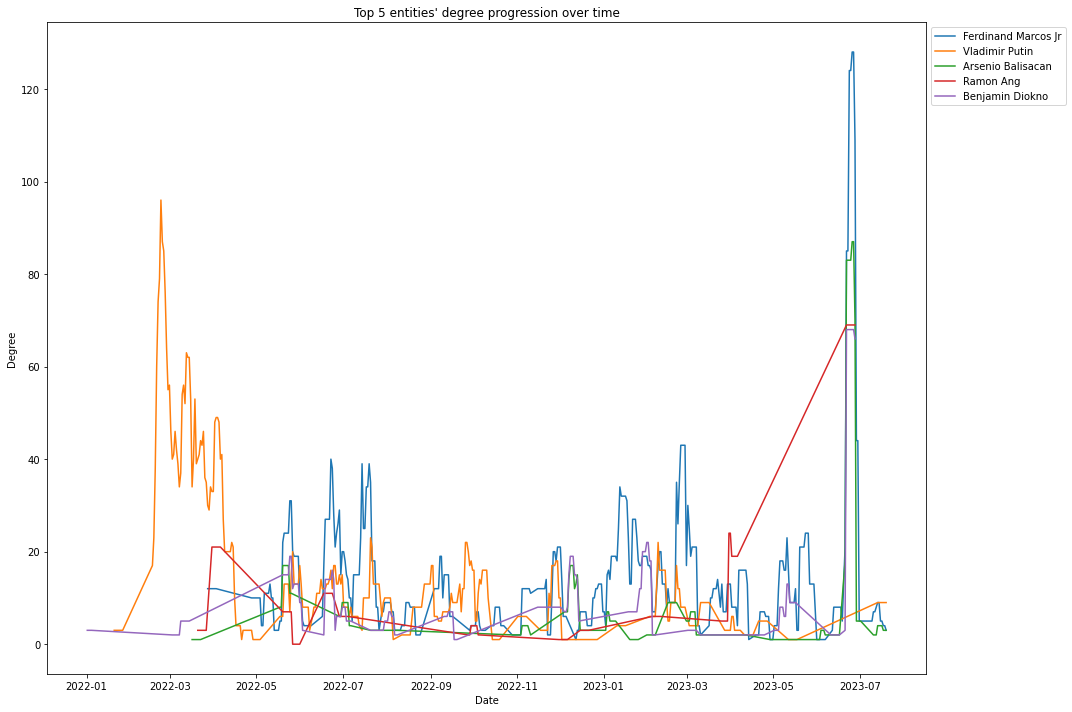

In [24]:
# Usage
rolling_window_analysis(df, 5)